#### Running A/B tests to find out if the new page or the old page is better for a website. 
    - Steps Include 
        > Probability
        > A/B Tests
        > Regression
        
    

In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
random.seed(42)
import statsmodels.api as sm
from scipy.stats import norm

In [252]:
# Read the ab data file
ab_data = pd.read_csv('./data/ab_data.csv')
ab_data.head(20)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [253]:
# Count the number of unique users in the dataset
len(ab_data['user_id'].unique())
# ab_data['user_id'].nunique()


290584

In [254]:
# Proportion of users converted 
converted_count = ab_data[ab_data["converted"] == 1]
converted_count['converted'].count()
# ab_data['converted'].mean() * 100 
percentage = '{0:.2f}'.format(ab_data['converted'].mean() * 100 ) + "%"
percentage

'11.97%'

In [255]:
# Number of times landing page comes new_page for the controlled group
mismatch_control = ab_data.query('group == "control" and landing_page == "new_page" ')
len(mismatch_control)
# mismatch_control = ab_data[ab_data['group'] == "control"]
# mismatch_control = xx[xx['landing_page'] == "new_page"]
# mismatch_control['user_id'].count()

# Number of times landing page comes old_page for the experiment group
mismatch_experiment = ab_data.query('group == "treatment" and landing_page == "old_page"')
len(mismatch_experiment)

# Total number of time new_page and treatment don't line up
len(mismatch_experiment) + len(mismatch_control)


3893

In [256]:
# Check if any row has some missing values
# If it matches the ab_data.shape, then there is no missing values
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [257]:
# For the rows where treatment is not aligned with new_page or control is not aligned with old_page, we cannot be sure if this row truly received the new or old page. 
# We need to create a new dataset by dropping the mismatched treatment and controlled groups 
ab_data.drop(ab_data.query('group == "treatment" and landing_page == "old_page"').index, inplace = True)
ab_data.drop(ab_data.query('group == "control" and landing_page == "new_page"').index, inplace = True)

In [258]:
# Final check to see all the incorrect values were removed
ab1 = ab_data[((ab_data['group'] == 'treatment') == (ab_data['landing_page'] == 'new_page')) == False].shape[0]
ab2 = ab_data[((ab_data['group'] == 'control') == (ab_data['landing_page'] == 'old_page')) == False].shape[0]
ab1 == ab2 == 0

True

In [259]:
# Save the data to a new csv file
ab_data.to_csv('data/ab_data_new.csv', index = False)

In [260]:
# Open the new dataset csv file
ab_data_new = pd.read_csv('data/ab_data_new.csv')
ab_data.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [261]:
# Counting the unique user id's in the new dataframe
count_unique = len(ab_data_new['user_id'].unique())
print("Total unique ID's are: ", count_unique)

Total unique ID's are:  290584


In [262]:
# As the total number of rows in the dataset is 290585 and the total number of unique id's is 20584
sum(ab_data_new['user_id'].duplicated())
# Finding the 1 id that is duplicated
ab_data_new[ab_data_new.duplicated(['user_id'], keep=False) ]

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [263]:
# Removing one of the duplicated rows using the row label
ab_data_new.drop(labels = 2862, inplace = True )

In [264]:
# Check the shape of the dataset to check the unique rows
ab_data_new.shape

(290584, 5)

In [265]:
# Percentage of individuals to convert regardless of the page they receive
converted_mean = ab_data_new['converted'].mean()
print('Probability of converted individuals: ', round((converted_mean * 100), 3), "%")

Probability of converted individuals:  11.96 %


In [266]:
# Describe the converted rate for both control and treatment 
converted_rate = ab_data_new.groupby('group')
converted_rate.describe()

user_id                                                    \
              count           mean           std       min        25%   
group                                                                   
control    145274.0  788164.072594  91287.914601  630002.0  709279.50   
treatment  145310.0  787845.719290  91161.564429  630000.0  708745.75   

                                         converted                           \
                50%        75%       max     count      mean       std  min   
group                                                                         
control    788128.5  867208.25  945998.0  145274.0  0.120386  0.325414  0.0   
treatment  787876.0  866718.75  945999.0  145310.0  0.118808  0.323564  0.0   

                               
           25%  50%  75%  max  
group                          
control    0.0  0.0  0.0  1.0  
treatment  0.0  0.0  0.0  1.0

In [267]:
# Probability of the converted prople who belongs to control group
converted_controlled_probability = len(ab_data_new.query('group == "control" and converted == 1')) / len(ab_data_new.query('group == "control"'))
converted_controlled_probability

0.1203863045004612

In [268]:
# Probability of the converted prople who belongs to treatment group
converted_experiment_probability = len(ab_data_new.query('group == "treatment" and converted == 1')) / len(ab_data_new.query('group == "treatment"'))
converted_experiment_probability

0.11880806551510564

In [269]:
# Probability that an individual received a new page
new_page_received = len(ab_data_new.query('group == "treatment"')) / len(ab_data_new)
new_page_received 

0.5000619442226688

#### Some of the conclusions made are: 
    - It comes out that the probability of the individuals who converted and belongs to the control group is 0.1203863045004612
    - It comes out that the probability of the individuals who converted and belongs to the treatment group is 0.11880806551510564
    - And the probability of the individuals who received a new page is 0.5000619442226688

$$ \text{For  A/B     Tests} $$
$$ H_0: p_{new} \leq p_{old} \text{ (Null Hypothests)}$$
$$ H_1: p_{new} \geq p_{old} \text{ (Alternate Hypothesis)}$$

In [270]:
# Finding the conversion rate of p_{new} and p_{old} under the null hypothesis
# As the null hypothesis states that there is no difference between the conversion rates of 
# old and new page. We will find it using the entire dataset
conversion_p_new = ab_data_new['converted'].mean()
conversion_p_old = ab_data_new['converted'].mean()

In [271]:
# Calculate the number of users landed in the new page and old page
n_new_page = len(ab_data_new.query('landing_page == "new_page"'))
n_old_page = len(ab_data_new.query('landing_page == "old_page"'))
print('New Page: ', n_new_page, 'and old page: ', n_old_page)

New Page:  145310 and old page:  145274


In [272]:
# Simulate $n_new_page$ transactions with a convert rate of $conversion_p_new$ under the null. Store these $n_new_page$ 1's and 0's in new_page_converted.

# new_page_converted = np.random.choice([1, 0], size=n_new_page, p=[conversion_p_new, (1-conversion_p_new)])
new_page_converted = np.random.binomial(1, conversion_p_new, n_new_page)
print(new_page_converted, "  Mean:", new_page_converted.mean())

[0 0 0 ... 0 0 0]   Mean: 0.11984722317803317


In [273]:
# Simulate $n_old_page$ transactions with a convert rate of $conversion_p_old$ under the null. Store these $n_old_page$ 1's and 0's in new_page_converted.

# old_page_converted = np.random.choice([1, 0], size=n_old_page, p=[conversion_p_old, (1-conversion_p_old)])
old_page_converted = np.random.binomial(1, conversion_p_old, n_old_page)
print(old_page_converted, "  Mean:", old_page_converted.mean())

[0 0 0 ... 0 0 0]   Mean: 0.11926428679598551


In [274]:
# Finding the $conversion_p_new$ - $conversion_p_old$ 
# for your simulated values from new_page_converted and old_page_Conv(erted.

# Since, the size of new_page_converted and old_page_converted is different
new_page_converted = new_page_converted[:145274]
page_diff = new_page_converted.mean() - old_page_converted.mean()
print(page_diff)

0.0005713341685367052


#### Simulating 10,000 $p_{new}$ - $p_{old}$ values. Store all 10,000 values in p_diffs. Here, value of size is different for n_new and n_old. So, computing difference will throw an error. Hence, we use mean function for both old and new page conversion simulations to overcome this problem of shape difference. We are still using probabilities as previous case.


In [275]:
# Bootstrapping for 10000 simulations
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1,conversion_p_new,n_new_page).mean()
    old_page_converted = np.random.binomial(1,conversion_p_old,n_old_page).mean()
    p_diffs.append(new_page_converted - old_page_converted)

In [276]:
print(p_diffs[:10])

[0.000982185356347226, -0.0005114431179450152, -0.0015233820978775986, 0.0023998577977533825, 0.000163130570605019, 1.8673348619477337e-05, 0.0010990725887258523, -0.00011205430314942255, 0.0014497615718121748, -0.0010206463246387881]


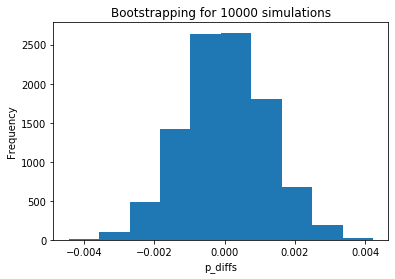

In [277]:
# Plotting a histogram for the abpve resuls

# Converting the p_diffs array into numpy array
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Bootstrapping for 10000 simulations');

In [278]:
# Checking the proportion of the p_diffs that are greater than the 
# actual difference observed in ab_data.csv
actual_diff = ab_data.query('group == "treatment"')['converted'].mean() - ab_data.query('group == "control"')['converted'].mean() 
print("Actual difference is: ", actual_diff)

Actual difference is:  -0.0015790565976871451


In [279]:
(p_diffs > actual_diff).mean()

0.9118

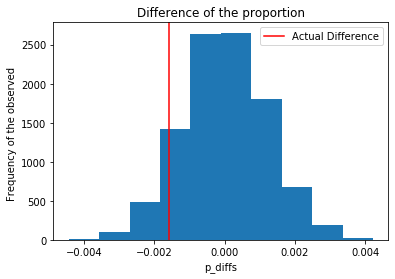

In [280]:
# Plotting the observed statistics
plt.hist(p_diffs)
plt.axvline(x = actual_diff, color='r', label="Actual Difference")
plt.legend()
plt.xlabel('p_diffs')
plt.ylabel('Frequency of the observed ')
plt.title('Difference of the proportion')
plt.show()

In [281]:
# Computting the test statistic and p-value
convert_old = len(ab_data_new.query('group == "control" and converted == "1"'))
convert_new = len(ab_data_new.query('group == "treatment" and converted == "1"'))
old_page = len(ab_data_new.query('group == "control"')['converted'])
new_page = len(ab_data_new.query('group == "treatment"')['converted'])
convert_old, convert_new, old_page, new_page

(17489, 17264, 145274, 145310)

In [282]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [old_page, new_page], alternative='smaller')
print("z-score:", z_score)
print('p-value: ', p_value)

z-score: 1.3109241984234394
p-value:  0.9050583127590245


In [283]:
# Finding the cdf and pdf for the z-value and p-value

# To find the significance of the z-score
print(norm.cdf(z_score))

# For 95% condifence interval to find out the critical value at 95%
print(norm.ppf(1-(0.05)))

0.9050583127590245
1.6448536269514722


#### Conclusions made:
    - The P-value comes out to be 0.90290000000000004.
    - It is evident from the z-score of 1.3109241984234394 which is less than the critical score of 1.64485. So, we follow the initial one and accept the null hypothesis. Also, it comes out the old pages are only very slighty better than the old pages.
    

### Using Regression approach for the above

In [284]:
# ab_data_new['intercept'] = 1
ab_data[['control', 'treatment']] = pd.get_dummies(ab_data['group'])
ab_data['intercept'] = 1

In [285]:
# Drop one of the dummy dataframe
ab_data = ab_data.drop('control', axis = 1)

In [286]:
ab_data.head()

,user_id,timestamp,group,landing_page,converted,treatment,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


In [287]:
logit = sm.Logit(ab_data['converted'], ab_data[['intercept','treatment']])

In [288]:
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Sat, 27 Jun 2020   Pseudo R-squ.:               8.085e-06
Time:                        01:11:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

In [289]:
# Checking the effect of the location 
df_countries = pd.read_csv('./data/countries.csv')
df_countries.head(10)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK
5,909908,UK
6,811617,US
7,938122,US
8,887018,US
9,820683,US


In [290]:
ab_data.head()

,user_id,timestamp,group,landing_page,converted,treatment,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


In [291]:
# Add the country and ab_data_new df values to a new dataframe
new_countries = df_countries.set_index('user_id').join(ab_data_new.set_index('user_id'), how='inner')
new_countries.head()

,country,timestamp,group,landing_page,converted
user_id,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0


In [292]:
# Get the count of total number of sets from each country
# count_countries = new_countries['country'].value_counts()
# print("US: ", count_countries[0])
# print("UK: ", count_countries[1])
# print("CA: ", count_countries[2])
new_countries['country'].astype(str).value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [293]:
# Creating the dummy variables for categoral data in logistic regression
new_countries[['CA', 'US', 'UK']] = pd.get_dummies(new_countries['country'])
new_countries.head()

,country,timestamp,group,landing_page,converted,CA,US,UK
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,0


In [294]:
# Drop one the dummy column
new_countries = new_countries.drop('UK', axis = 1)

In [295]:
# Using the same method above, using Logit to get the summary
logit_countries = sm.Logit(new_countries['converted'], new_countries[['US','CA']])
logit_countries_result = logit_countries.fit()
print(logit_countries_result.summary())
print(np.exp(logit_countries_result.params))

Optimization terminated successfully.
         Current function value: 0.595341
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 27 Jun 2020   Pseudo R-squ.:                 -0.6261
Time:                        01:11:43   Log-Likelihood:            -1.7300e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
US            -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -2.0375      0.

In [296]:
1/_

0.00010001000100010001

#### Conclusions made:
    - Using logistic regression we found out that the values does not show a substantial difference to the conversion rates fo the two groups and we can accept the initial null hypothesis (keeping the old pages).